In [10]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Windows 기본 한글 폰트 설정
plt.rcParams['font.family'] = 'pretendard'  # '맑은 고딕'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

In [2]:
import pandas as pd

# 파일 불러오기
승인매출정보 = pd.read_parquet("merged_승인매출정보.parquet")
회원정보 = pd.read_parquet("merged_회원정보.parquet")

online_offline_cols   = [col for col in 승인매출정보.columns if '_온라인' in col or '_오프라인' in col]


온오프라인 = 승인매출정보[['ID'] + online_offline_cols ]

total = 온오프라인.groupby('ID')[online_offline_cols ].mean().reset_index()

# 회원정보에서 ID와 Segment 추출
회원_선택 = 회원정보[['ID', 'Segment']]

# 병합 (고객 단위로)
병합결과 = pd.merge(total, 회원_선택, on='ID', how='left')

# 확인
print("병합 후 shape:", 병합결과.shape)
print(병합결과.head())


병합 후 shape: (2400000, 31)
             ID  쇼핑_온라인_이용금액  이용개월수_온라인_R6M  이용개월수_오프라인_R6M  이용금액_온라인_R6M  \
0  TRAIN_000000          0.0       0.666667             6.0    400.333333   
1  TRAIN_000000          0.0       0.666667             6.0    400.333333   
2  TRAIN_000000          0.0       0.666667             6.0    400.333333   
3  TRAIN_000000          0.0       0.666667             6.0    400.333333   
4  TRAIN_000000          0.0       0.666667             6.0    400.333333   

   이용금액_오프라인_R6M  이용건수_온라인_R6M  이용건수_오프라인_R6M  이용금액_온라인_R3M  이용금액_오프라인_R3M  \
0   15400.833333           0.0           42.5           0.0         9343.0   
1   15400.833333           0.0           42.5           0.0         9343.0   
2   15400.833333           0.0           42.5           0.0         9343.0   
3   15400.833333           0.0           42.5           0.0         9343.0   
4   15400.833333           0.0           42.5           0.0         9343.0   

   ...  이용건수_페이_오프라인_R6M  이용금액_페이_온라인_R3M 

In [5]:
# '_건수' 포함 + '_온라인' or '_오프라인' 포함된 컬럼 추출
online_offline_cnt_cols = [col for col in 승인매출정보.columns
                           if '건수' in col and ('_온라인' in col or '_오프라인' in col)]

# 확인
print("온라인/오프라인 이용건수 관련 컬럼:")
print(online_offline_cnt_cols)

온라인/오프라인 이용건수 관련 컬럼:
['이용건수_온라인_R6M', '이용건수_오프라인_R6M', '이용건수_온라인_R3M', '이용건수_오프라인_R3M', '이용건수_온라인_B0M', '이용건수_오프라인_B0M', '이용건수_페이_온라인_R6M', '이용건수_페이_오프라인_R6M', '이용건수_페이_온라인_R3M', '이용건수_페이_오프라인_R3M', '이용건수_페이_온라인_B0M', '이용건수_페이_오프라인_B0M']


In [6]:
# 필요한 컬럼만 추출
건수정보 = 승인매출정보[['ID'] + online_offline_cnt_cols]

# 고객별 평균 이용건수 집계
ID별_건수평균 = 건수정보.groupby('ID')[online_offline_cnt_cols].mean().reset_index()

In [8]:
# Segment 병합
회원_선택 = 회원정보[['ID', 'Segment']]
건수_세그먼트 = pd.merge(ID별_건수평균, 회원_선택, on='ID', how='left')

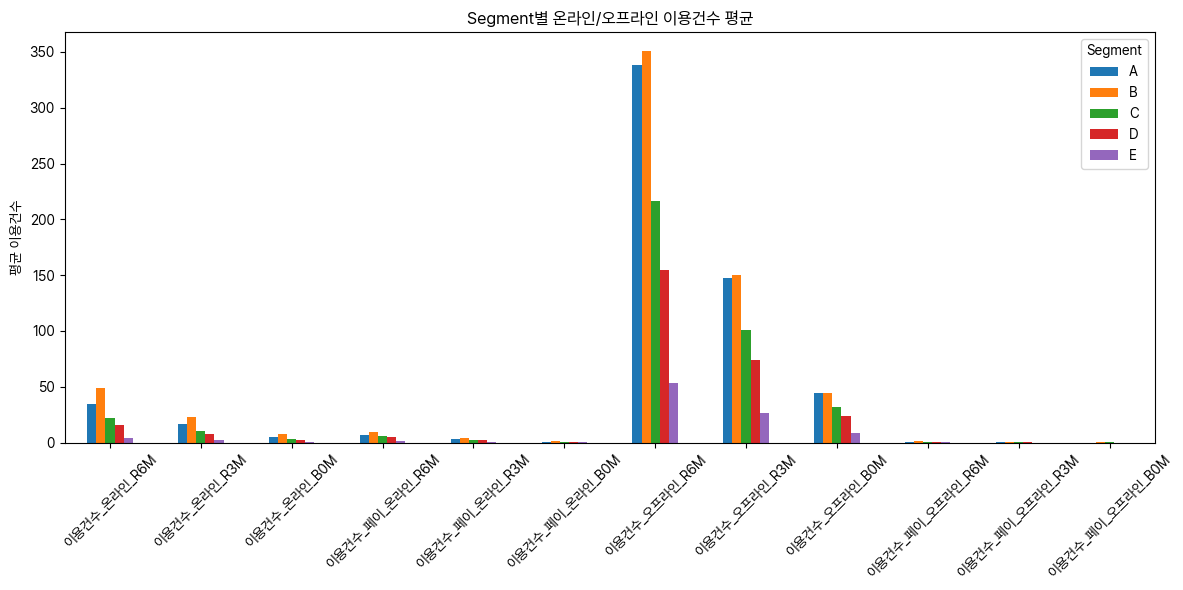

In [11]:
import matplotlib.pyplot as plt

# 온라인 평균
온라인_컬럼 = [col for col in online_offline_cnt_cols if '_온라인' in col]
오프라인_컬럼 = [col for col in online_offline_cnt_cols if '_오프라인' in col]

# Segment별 평균
segment_avg = 건수_세그먼트.groupby('Segment')[온라인_컬럼 + 오프라인_컬럼].mean()

# 시각화
segment_avg.T.plot(kind='bar', figsize=(12,6), title="Segment별 온라인/오프라인 이용건수 평균")
plt.xticks(rotation=45)
plt.ylabel("평균 이용건수")
plt.tight_layout()
plt.show()

In [22]:
# ID 기준으로 평균값 집계 → 중복 제거
고객별 = 병합결과.groupby('ID').mean(numeric_only=True).reset_index()

# Segment는 문자형이므로 별도로 ID 기준 대표값 병합
고객_Segment = 병합결과[['ID', 'Segment']].drop_duplicates()
고객별 = pd.merge(고객별, 고객_Segment, on='ID', how='left')

In [23]:
# 온라인/오프라인 건수 컬럼 리스트 생성
온라인건수 = [col for col in 고객별.columns if '온라인' in col and '건수' in col]
오프라인건수 = [col for col in 고객별.columns if '오프라인' in col and '건수' in col]

# 총합 계산
고객별['총_온라인_건수'] = 고객별[온라인건수].sum(axis=1)
고객별['총_오프라인_건수'] = 고객별[오프라인건수].sum(axis=1)
고객별['총_이용건수'] = 고객별['총_온라인_건수'] + 고객별['총_오프라인_건수']

# 비중 계산
고객별['온라인_비중'] = 고객별['총_온라인_건수'] / 고객별['총_이용건수']
고객별['오프라인_비중'] = 고객별['총_오프라인_건수'] / 고객별['총_이용건수']

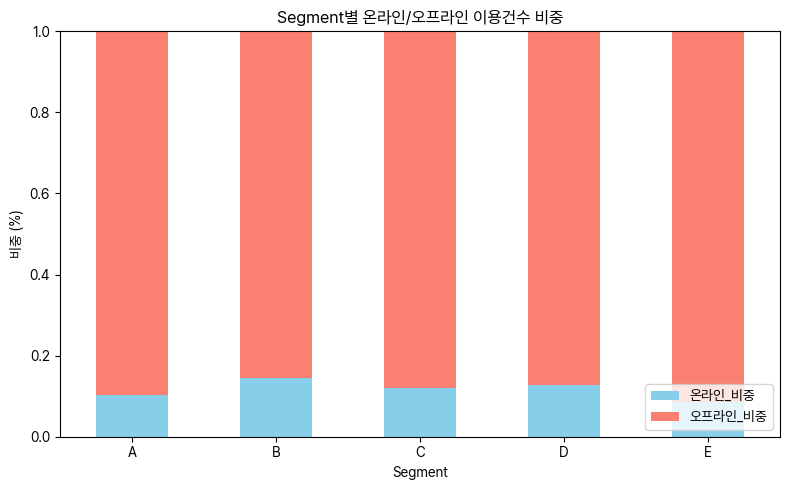

In [24]:
segment_ratio = 고객별.groupby('Segment')[['온라인_비중', '오프라인_비중']].mean().reset_index()

# 시각화
segment_ratio.set_index('Segment').plot(kind='bar', stacked=True, figsize=(8,5), color=['skyblue', 'salmon'])
plt.title('Segment별 온라인/오프라인 이용건수 비중')
plt.ylabel('비중 (%)')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [25]:
# 고객별 데이터에서 페이 관련 이용건수만 추출
페이_온라인 = [col for col in 고객별.columns if '이용건수_페이_온라인' in col]
페이_오프라인 = [col for col in 고객별.columns if '이용건수_페이_오프라인' in col]

In [26]:
# 고객 단위 페이 이용건수 합계
고객별['페이_온라인_건수'] = 고객별[페이_온라인].sum(axis=1)
고객별['페이_오프라인_건수'] = 고객별[페이_오프라인].sum(axis=1)
고객별['총_페이_건수'] = 고객별['페이_온라인_건수'] + 고객별['페이_오프라인_건수']

In [27]:
# 총 이용건수가 이미 계산된 상태여야 함 (이전 단계에서 수행한 '총_이용건수')
고객별['페이_비중'] = 고객별['총_페이_건수'] / 고객별['총_이용건수']
고객별['페이_온라인_비중'] = 고객별['페이_온라인_건수'] / 고객별['총_이용건수']
고객별['페이_오프라인_비중'] = 고객별['페이_오프라인_건수'] / 고객별['총_이용건수']


In [28]:
segment_페이비중 = 고객별.groupby('Segment')[['페이_비중', '페이_온라인_비중', '페이_오프라인_비중']].mean().reset_index()

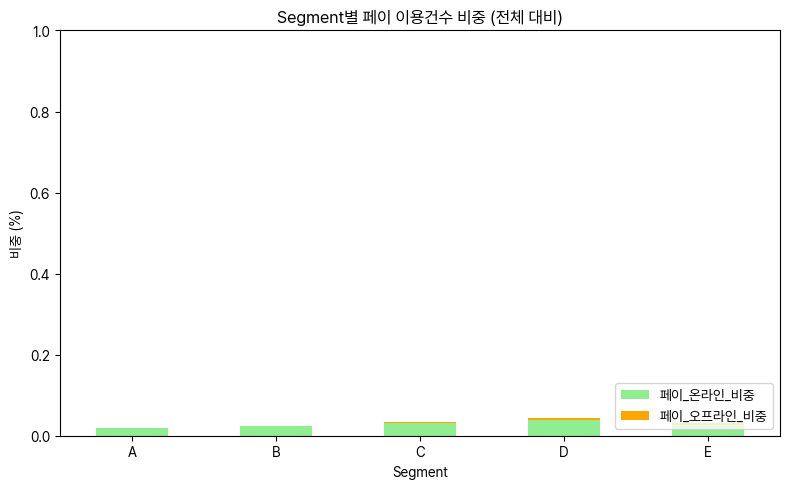

In [29]:
segment_페이비중.set_index('Segment')[['페이_온라인_비중', '페이_오프라인_비중']].plot(
    kind='bar', stacked=True, figsize=(8,5), color=['lightgreen', 'orange'])

plt.title('Segment별 페이 이용건수 비중 (전체 대비)')
plt.ylabel('비중 (%)')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [30]:
def 가중_평균(df, value_col, weight_col):
    return (df[value_col] * df[weight_col]).sum() / df[weight_col].sum()

In [31]:
# 빈 딕셔너리로 결과 저장
weighted_results = []

# Segment별 반복
for seg, group in 고객별.groupby('Segment'):
    row = {
        'Segment': seg,
        '가중_페이_비중': 가중_평균(group, '페이_비중', '총_이용건수'),
        '가중_페이_온라인_비중': 가중_평균(group, '페이_온라인_비중', '총_이용건수'),
        '가중_페이_오프라인_비중': 가중_평균(group, '페이_오프라인_비중', '총_이용건수')
    }
    weighted_results.append(row)

# 데이터프레임 변환
segment_가중비중 = pd.DataFrame(weighted_results)


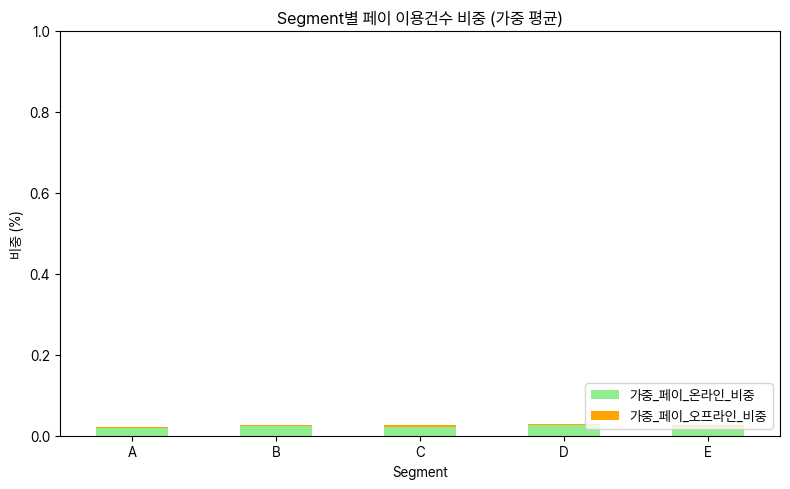

In [32]:
segment_가중비중.set_index('Segment')[['가중_페이_온라인_비중', '가중_페이_오프라인_비중']].plot(
    kind='bar', stacked=True, figsize=(8,5), color=['lightgreen', 'orange'])

plt.title('Segment별 페이 이용건수 비중 (가중 평균)')
plt.ylabel('비중 (%)')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


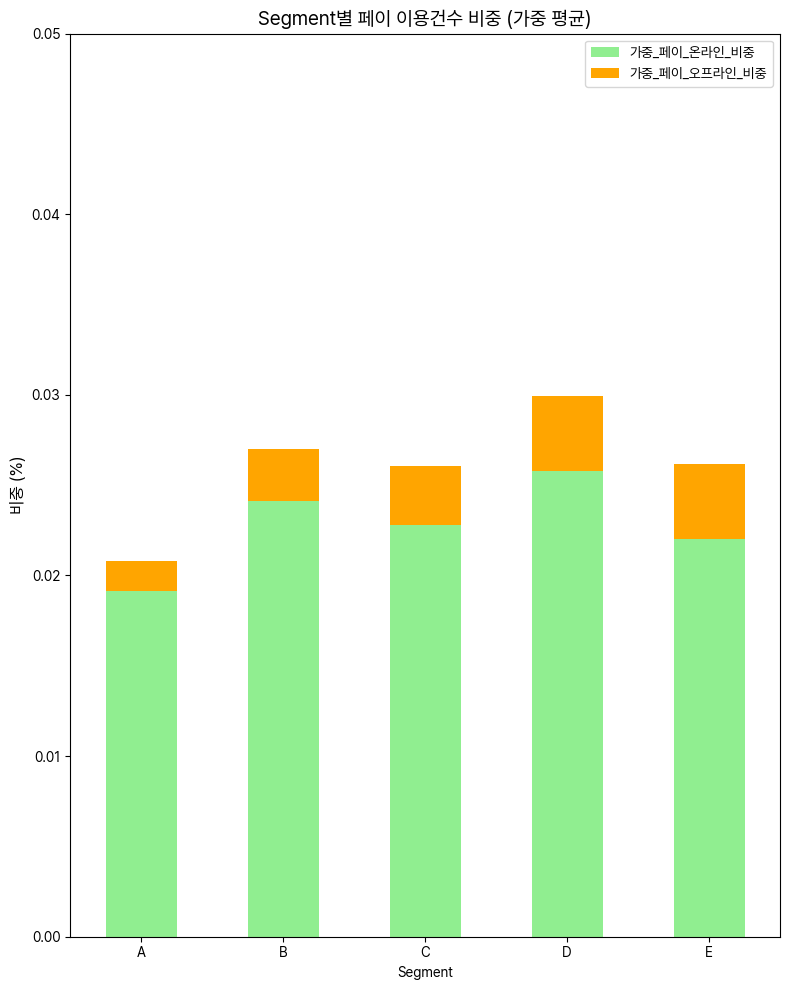

In [33]:
segment_가중비중.set_index('Segment')[['가중_페이_온라인_비중', '가중_페이_오프라인_비중']].plot(
    kind='bar', stacked=True, figsize=(8,10),  # ← 세로 길이 증가
    color=['lightgreen', 'orange'])

plt.title('Segment별 페이 이용건수 비중 (가중 평균)', fontsize=14)
plt.ylabel('비중 (%)', fontsize=12)
plt.ylim(0, 0.05)  # ← 비중이 작으므로 범위 좁게 조정
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


D : 온라인페이 중심
A : 디지털 경제 활용도 낮음

In [35]:
# 페이 관련 컬럼만 추출
페이_R6M_컬럼 = [col for col in 승인매출정보.columns
              if 'R6M' in col and
              any(x in col for x in ['간편결제', '당사페이', '당사기타', 'A페이', 'B페이', 'C페이', 'D페이']) and
              any(y in col for y in ['이용개월수', '이용건수', '이용금액'])]

# 필요한 컬럼만 추출
페이_데이터 = 승인매출정보[['ID'] + 페이_R6M_컬럼]

In [36]:
# 고객 단위 평균 집계 (월별 데이터를 평균으로 통합)
페이_고객단위 = 페이_데이터.groupby('ID').mean(numeric_only=True).reset_index()

In [37]:
# Segment 정보 가져오기
회원_Segment = 회원정보[['ID', 'Segment']]

# 병합
페이_완성 = pd.merge(페이_고객단위, 회원_Segment, on='ID', how='left')

In [38]:
print("Segment 포함된 페이 데이터 shape:", 페이_완성.shape)
페이_완성.head()

Segment 포함된 페이 데이터 shape: (2400000, 23)


,ID,이용개월수_간편결제_R6M,이용개월수_당사페이_R6M,이용개월수_당사기타_R6M,이용개월수_A페이_R6M,이용개월수_B페이_R6M,이용개월수_C페이_R6M,이용개월수_D페이_R6M,이용금액_간편결제_R6M,이용금액_당사페이_R6M,...,이용금액_C페이_R6M,이용금액_D페이_R6M,이용건수_간편결제_R6M,이용건수_당사페이_R6M,이용건수_당사기타_R6M,이용건수_A페이_R6M,이용건수_B페이_R6M,이용건수_C페이_R6M,이용건수_D페이_R6M,Segment
0,TRAIN_000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D
1,TRAIN_000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D
2,TRAIN_000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D
3,TRAIN_000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D
4,TRAIN_000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D


In [39]:
# 페이 관련 컬럼만 추출
페이_컬럼 = [col for col in 페이_완성.columns 
            if any(x in col for x in ['간편결제', '당사페이', '당사기타', 'A페이', 'B페이', 'C페이', 'D페이']) and
               any(y in col for y in ['이용건수', '이용금액', '이용개월수']) and
               'R6M' in col]

In [40]:
# 사용 여부로 0/1 변환 (0 → 미사용, >0 → 사용)
사용여부 = 페이_완성.copy()
사용여부[페이_컬럼] = 사용여부[페이_컬럼].applymap(lambda x: 1 if x > 0 else 0)

C:\Users\somee\AppData\Local\Temp\ipykernel_27488\2831608564.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  사용여부[페이_컬럼] = 사용여부[페이_컬럼].applymap(lambda x: 1 if x > 0 else 0)


In [41]:
# Segment별 평균 사용률 계산
세그먼트별_사용비율 = 사용여부.groupby('Segment')[페이_컬럼].mean().reset_index()

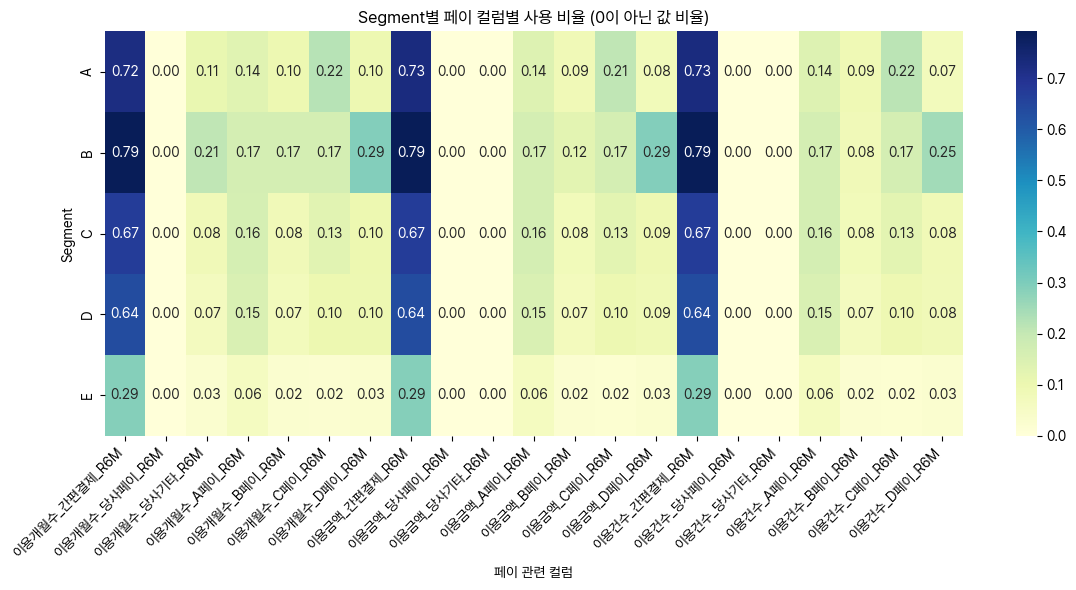

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(세그먼트별_사용비율.set_index('Segment'), annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Segment별 페이 컬럼별 사용 비율 (0이 아닌 값 비율)")
plt.ylabel("Segment")
plt.xlabel("페이 관련 컬럼")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
